# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 


## Описание признаков
Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента


## Оглавление

1. Первичный анализ данных
2. Предобработка данных
3. Исследование данных
4. Исследование моделей машинного обучения
5. Финальное тестирование

In [1]:
# блок импорта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import missingno as msno
import random
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

# Подготовка моделей
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Первичный анализ данных

In [2]:
try:
    df = pd.read_csv('Churn.csv')
except FileNotFoundError: 
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.tail(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9990,9991,15798964,Nkemakonam,714,Germany,Male,33,3.0,35016.60,1,1,0,53667.08,0
9991,9992,15769959,Ajuluchukwu,597,France,Female,53,4.0,88381.21,1,1,0,69384.71,1
9992,9993,15657105,Chukwualuka,726,Spain,Male,36,2.0,0.00,1,1,0,195192.40,0
9993,9994,15569266,Rahman,644,France,Male,28,7.0,155060.41,1,1,0,29179.52,0
9994,9995,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


## Вывод по первичному анализу данных
- Пропуски наблюдатся в единственном столбце `Tenure`. Это может означать, что клиент пользуется услугами банка менее года и данные о количестве лет для него не были заполнены.
- Также в столбце `Tenure` изменим тип данных с `float64` -> `int64`.
- Столбцы `RowNumber` и `CustomerId` не помогут нам при обучении модели машинного обучения, разве что для создания консперологических теорий, построенных на нумерологии. (удалим их)
- Столбец `Surname` также наврядли поможет машине определить вероятность расторжения договора с банком, удалим данных столбец.
- Количественные признаки `Gender` и `Geography` преобразуем к числовым значениям. (вероятней всего методом Ohe)

# Предобработка данных

In [5]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)

In [6]:
# Приведем столбы к нижнему индексу с помощью list comprehension и lower
df.columns =[column.lower() for column in df.columns]

df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [7]:
(df.set_axis(
    ['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_crcard', 'is_active_member', 'estimated_salary',
       'exited'], axis = 'columns', inplace = True)
)

In [8]:
df.duplicated().sum() #Дубликатов не обнаружено 

0

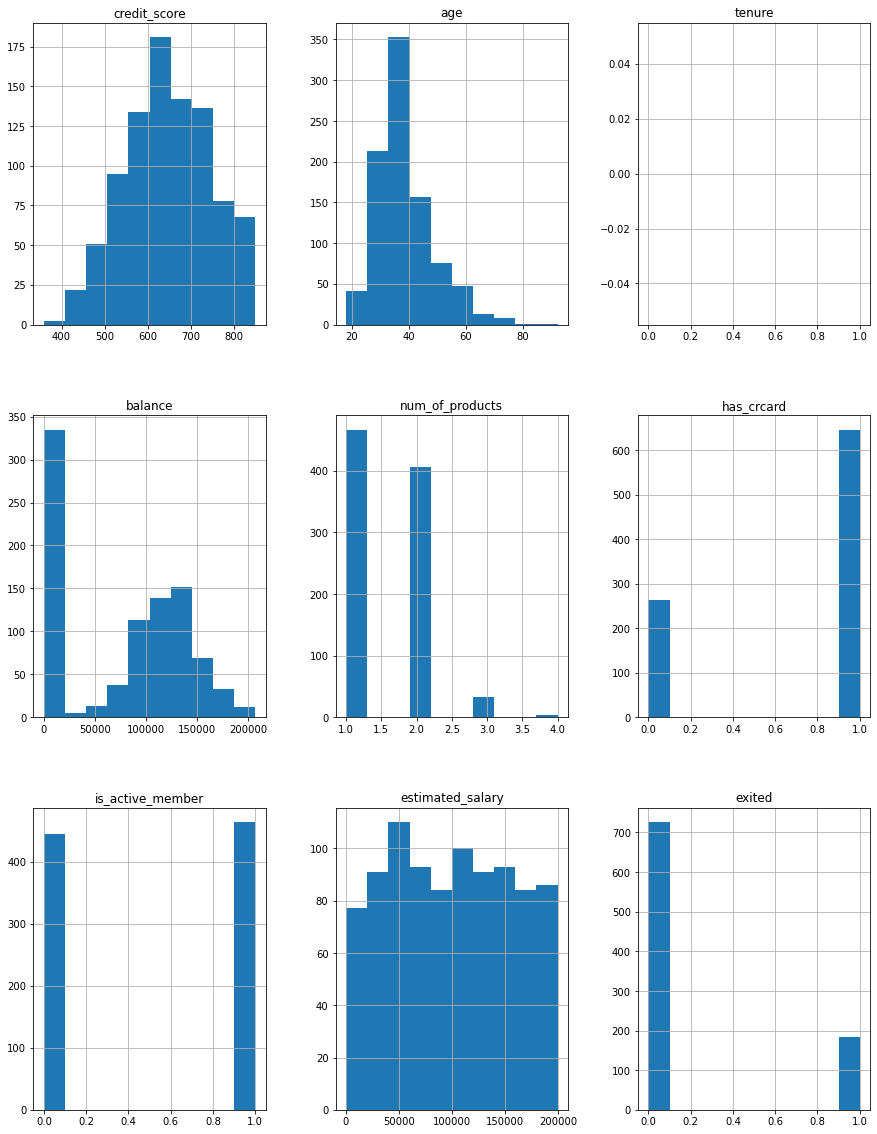

In [9]:
df[df['tenure'].isnull()].hist(figsize=(15, 20));

## Промежуточный вывод
Все графики в отфильтрованной выборке являются `нормальными`. 

Есть лишь одно интересное наблюдение баланса на счетах людей не имеющих данных в столбце `Tenure`. Большая доля таких клиентов имеет нулевой баланс.

<AxesSubplot:>

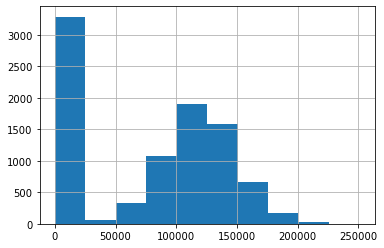

In [10]:
# Предположение об уникальности данных на графике Balance среди клиентов с пропусками не оправдались.
df[df['tenure'].notnull()]['balance'].hist() 

In [11]:
def missing_tenure(row):
    if math.isnan(row['tenure']):
        return (random.randint(0,10))
    
    return row['tenure']

In [12]:
df['tenure'] = df.apply(missing_tenure, axis=1)

In [13]:
df['tenure'] = df['tenure'].astype('int64')

df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Категориальные признаки

In [14]:
df['gender'].value_counts() # Шесть или пять полов напридумывали, трансформеры, трансгендеры слава богу в этом датасете всё традиционно :)

Male      5457
Female    4543
Name: gender, dtype: int64

In [15]:
df['geography'].value_counts() #Три европейские страны - ок 

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

## Промежуточный вывод
Резюмируя проделанные опирации и сделанные ранее выводы приходим к выводу, что для нас идеально подойдет метод OHE для дальнейшей подготовки данных.

<AxesSubplot:title={'center':'Распределение целевого признака'}, xlabel='Значение признака', ylabel='Количество записей с соответствующим значением'>

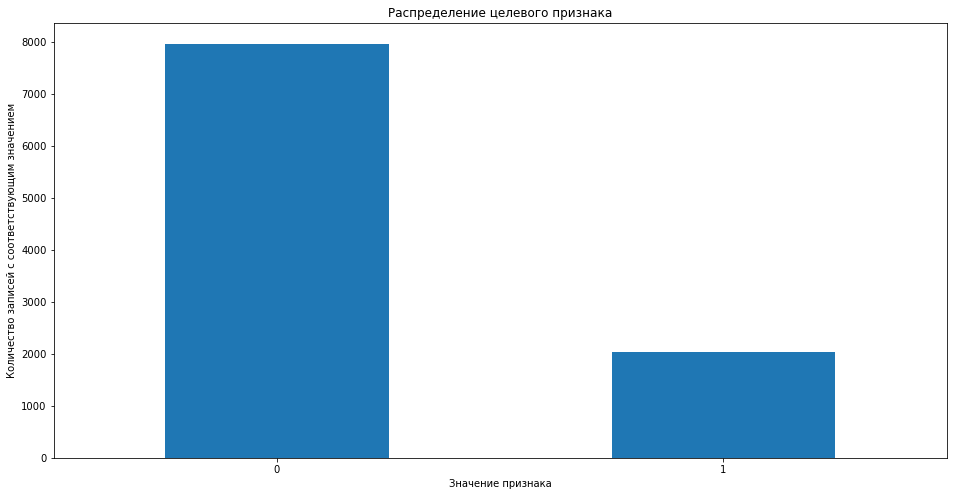

In [16]:
# Наблюдается сильнейший перевес в сторону класса 0.
fig, ax = plt.subplots(1)
ax.set_title('Распределение целевого признака')
ax.set_xlabel('Значение признака')
ax.set_ylabel('Количество записей с соответствующим значением')
df.exited.value_counts().plot(kind='bar', figsize=(16,8), ax=ax, rot=0)

In [17]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,credit_score,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


In [18]:
random_state = 12345

In [19]:
# Разделим датасет на две части. Первая содержит все признаки. Вторая - целевой признак.
X = df_ohe.drop('exited', axis=1)
y = df_ohe['exited']

In [20]:
#Сначала отделим от датасета 60% наблюдений - это будет обучающая выборка. 
#Оставщиеся данные поделим пополам - на тестовую и валидационную выборки.
#Таким образом мы разобьем данные в соотношении 60/20/20.
features_train, features_valid, target_train, target_valid = train_test_split(X, y, test_size=0.4, random_state=random_state, stratify=y)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=random_state, stratify=target_valid)


In [21]:
print('Target test count = {}, Varget test count = {}, Train test count = {}'.format(target_test.count(), target_valid.count(), target_train.count()))

Target test count = 2000, Varget test count = 2000, Train test count = 6000


In [22]:
# Стандартизируем признаки
scaler = StandardScaler()
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler.fit(features_train[numeric])

pd.set_option('mode.chained_assignment', None)
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Посмотрим на тренировочной выборке что получилось
features_train

,credit_score,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.345681,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-1.376411,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.034519,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,1.723356,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.376411,0.879129,-0.914708,1,0,0.113236,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6172,-0.844611,0.381372,0.001263,0.180068,4.292357,1,1,0.117350,1,0,1
2360,-1.359935,0.190726,0.001263,0.547724,-0.914708,1,0,-0.192524,1,0,0
4499,-1.174418,0.476696,-0.343156,0.727840,-0.914708,0,0,0.531933,1,0,0
9162,0.155118,2.287837,-1.031993,0.449382,-0.914708,1,1,-1.307769,1,0,1


## Вывод по предобработке данных
- Название столбцов приведены к змеиному виду.
- Удалены столбцы ненужные для построения моделей машинного обучения, а именно `RowNumber`, `CustomerId`, `Surname`.
- Данные были изучены, пропуски в столбце `Tenure` были заполнены.
- Изучены признаки `gender` и `geography` с последующим их преобразованием алгоритмом OHE.
- Данные были успешно разбиты на три класса для тренировки, валидации и теста будущих моделей.
- Признаки были стандартизированы, а данные отмасштабированы.

# Исследование данных

In [23]:
# Поскольку мы все равно будем исследовать все метрики, а они имеют одинаковую сигнатуру,
# имеет смысл объеденить вывод в одну функцию, чтобы сразу получать все интересующие данные

def print_title():
    print('╎{: >10}╎{: >10}╎{: >10}╎{: >10}╎{: >10}╎{: >5}╎{: >6}╎{: >5}╎{: >5}╎'.format('Accuracy', 'Recall', 'Precision', 'F1', 'ROC-AUC', 'TP', 'TN', 'FP', 'FN'))
    
def print_info(target, predicted, probabilities):
    accuracy = accuracy_score(target, predicted) #Точность предсказания
    recall = recall_score(target, predicted) #Доля положительных ответов
    precision = precision_score(target, predicted) #Доля отрицательных ответов
    f1 = f1_score(target, predicted) #Объединение двух предыдущих метрик
    
    roc_auc = roc_auc_score(target, probabilities) 
    
    confusion_m = confusion_matrix(target, predicted); #Матрица неточностей
    TN = confusion_m[0][0]
    TP = confusion_m[1][1]
    FN = confusion_m[1][0]
    FP = confusion_m[0][1]
    
    print('╎{: >10f}╎{: >10f}╎{: >10f}╎{: >10f}╎{: >10f}╎{: >5}╎{: >6}╎{: >5}╎{: >5}╎'.format(accuracy, recall, precision, f1, roc_auc, TP, TN, FP, FN))

In [24]:
# По аналогии с прошлым проектом определим глобальный массив, где будем сохранять наши лучшие результаты для всех моделей машинного обучения
best_results = dict()
best_results['decision_tree'] = dict()
best_results['logistic_regression'] = dict()
best_results['random_forest'] = dict()

In [25]:
# Напишем функцию по выводу информации по нашей лучшим моделям.
def display_best_results(best_results):
    print('╎{: >20}╎{: >15}╎{: >25}╎{: >10}╎'.format('Model name', 'Train type', 'Params', 'F1'))
    for model_name in best_results:
        print()
        for train_type in best_results[model_name]:
            print('╎{: >20}╎{: >15}╎{: >25}╎{: >10.5f}╎'.format(
                model_name, train_type, 
                best_results[model_name][train_type]['params'], best_results[model_name][train_type]['f1']))

In [26]:
# Напишем функцию по выводу информации по нашей модели
# На вход функция получает две выборки для тренировки модели машинного обучения,
# а также два параметра касающиеся балансировки целевого признака
def check_decision_tree(features_train, target_train, class_weight, train_type):
    print('Decision tree')
    print('╎{: >9}'.format('max_depth'), end='')
    print_title()
    
    # Будем сразу считать лучшую меру и параметры, чтобы не искать глазами
    best_f1 = 0
    best_max_depth = 0
    for max_depth in range(2, 16, 1):
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, class_weight=class_weight)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        #
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        #
        print('╎{: >9}'.format(max_depth), end='')
        print_info(target_valid, predicted_valid, probabilities_one_valid)
        
        current_f1 = f1_score(target_valid, predicted_valid)
        if (current_f1 > best_f1):
            best_f1 = current_f1
            best_max_depth = max_depth
    
    # Воспользуемся тем, что питон будет искать наш словарь глобально
    best_results['decision_tree'][train_type] = dict()
    best_results['decision_tree'][train_type]['params'] = 'max_depth=' + str(best_max_depth)
    best_results['decision_tree'][train_type]['f1'] = best_f1

In [27]:
# Исследуем дерево решений. Пока не обращаем внимание на дисбаланс в целевом признаке и не меняем class_weight

check_decision_tree(features_train, target_train, None, 'default')

Decision tree
╎max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎        2╎  0.835000╎  0.438725╎  0.639286╎  0.520349╎  0.753960╎  179╎  1491╎  101╎  229╎
╎        3╎  0.840000╎  0.455882╎  0.654930╎  0.537572╎  0.803250╎  186╎  1494╎   98╎  222╎
╎        4╎  0.849000╎  0.401961╎  0.738739╎  0.520635╎  0.819892╎  164╎  1534╎   58╎  244╎
╎        5╎  0.857500╎  0.419118╎  0.780822╎  0.545455╎  0.849794╎  171╎  1544╎   48╎  237╎
╎        6╎  0.862500╎  0.473039╎  0.762846╎  0.583964╎  0.841613╎  193╎  1532╎   60╎  215╎
╎        7╎  0.859500╎  0.504902╎  0.722807╎  0.594517╎  0.826295╎  206╎  1513╎   79╎  202╎
╎        8╎  0.857000╎  0.448529╎  0.750000╎  0.561350╎  0.822813╎  183╎  1531╎   61╎  225╎
╎        9╎  0.843500╎  0.480392╎  0.659933╎  0.556028╎  0.795692╎  196╎  1491╎  101╎  212╎
╎       10╎  0.846000╎  0.492647╎  0.665563╎  0.566197╎  0.781947╎  201╎  1491╎  101╎  207╎
╎       11╎  0.835500╎  0.497549╎  0.620795╎  0.552381╎  0.762506╎

In [28]:
# Посмотрим на регрессию. Пока не обращаем внимание на дисбаланс в целевом признаке и не меняем class_weight

def check_logistic_regression(features_train, target_train, class_weight, train_type):
    print('Logistic regression')
    print_title()
    
    model = LogisticRegression(solver='liblinear', random_state=random_state, class_weight=class_weight)
    model.fit(features_train, target_train)
    #
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    #
    predicted_valid = model.predict(features_valid)
    print_info(target_valid, predicted_valid, probabilities_one_valid)
    
    # Воспользуемся тем, что питон будет искать наш словарь глобально
    best_results['logistic_regression'][train_type] = dict()
    best_results['logistic_regression'][train_type]['params'] = '-'
    best_results['logistic_regression'][train_type]['f1'] = f1_score(target_valid, predicted_valid)

In [29]:
check_logistic_regression(features_train, target_train, None, 'default')

Logistic regression
╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎  0.810000╎  0.200980╎  0.602941╎  0.301471╎  0.787782╎   82╎  1538╎   54╎  326╎


In [30]:
# Исследуем случайный лес. Пока не обращаем внимание на дисбаланс в целевом признаке и не меняем class_weight

def check_random_forest(features_train, target_train, class_weight, train_type):
    print('Random_forest')
    print('╎{: >13}╎{: >10}'.format('n_estimators', 'max_depth'), end='')
    print_title()

        # Будем сразу считать лучшую меру и параметры, чтобы не искать глазами
    best_f1 = 0
    best_max_depth = 0
    best_n_estimators = 0
    
    for estim in range(5, 24, 3):
        for max_depth in range(5, 24, 3):
            model = RandomForestClassifier(n_estimators=estim, max_depth=max_depth, random_state=random_state, class_weight=class_weight)
            model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            #
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            #
            print('╎{: >13}╎{: >10}'.format(estim, max_depth), end='')
            print_info(target_valid, predicted_valid, probabilities_one_valid)
            
            f1 = f1_score(target_valid, predicted_valid)
            if (f1 > best_f1):
                best_f1 = f1
                best_max_depth = max_depth
                best_n_estimators = estim
        
        print() # Для разделения вывода по количеству деревьев
    
    # Воспользуемся тем, что питон будет искать наш словарь глобально
    best_results['random_forest'][train_type] = dict()
    best_results['random_forest'][train_type]['params'] = 'estim=' + str(best_n_estimators) + '; max_depth=' + str(best_max_depth)
    best_results['random_forest'][train_type]['f1'] = best_f1

In [31]:
check_random_forest(features_train, target_train, None, 'default');

Random_forest
╎ n_estimators╎ max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎            5╎         5╎  0.860500╎  0.455882╎  0.765432╎  0.571429╎  0.836925╎  186╎  1535╎   57╎  222╎
╎            5╎         8╎  0.862000╎  0.460784╎  0.770492╎  0.576687╎  0.845427╎  188╎  1536╎   56╎  220╎
╎            5╎        11╎  0.856500╎  0.485294╎  0.720000╎  0.579795╎  0.833052╎  198╎  1515╎   77╎  210╎
╎            5╎        14╎  0.850000╎  0.497549╎  0.681208╎  0.575071╎  0.803202╎  203╎  1497╎   95╎  205╎
╎            5╎        17╎  0.854000╎  0.553922╎  0.672619╎  0.607527╎  0.808793╎  226╎  1482╎  110╎  182╎
╎            5╎        20╎  0.841500╎  0.531863╎  0.632653╎  0.577896╎  0.794484╎  217╎  1466╎  126╎  191╎
╎            5╎        23╎  0.840500╎  0.534314╎  0.628242╎  0.577483╎  0.816462╎  218╎  1463╎  129╎  190╎

╎            8╎         5╎  0.860500╎  0.424020╎  0.797235╎  0.553600╎  0.852936╎  173╎  1548╎   44╎  235╎
╎            8╎       

In [32]:
display_best_results(best_results)

╎          Model name╎     Train type╎                   Params╎        F1╎

╎       decision_tree╎        default╎              max_depth=7╎   0.59452╎

╎ logistic_regression╎        default╎                        -╎   0.30147╎

╎       random_forest╎        default╎   estim=14; max_depth=17╎   0.61404╎


## Промежуточный вывод
- За счет распределения ключевой метрики до сплита выборок на тренировочные, валидационные и тестовые уже на данном этапе модели машинного обучения показывают высокие показатели F1-меры. Лидирует на данном этапе `Случайный лес` с F1 = 0.61
- Рещающее дерево показывает себя также очень уверенно с показатем F1 = 0.587
- Логическая регрессия сильно проигрывает обоим деревьям по показатель F1.
- Стоит отметить, что на данном этапе `Accuracy` она же точность предсказания держится в районе 0.81-0.86, однако из-за дисбаланса классов целевого признака данная метрика не имеет должного веса.
- Также стоит ответить, что все без исключения модели на данном этапе хорошо предсказывают негативные исходы и ошибаются в половине и более случаях с положительным исходом.


# Исследование моделей машинного обучения

## Взвешивание классов признаков

In [33]:
check_decision_tree(features_train, target_train, 'balanced', 'balanced')

Decision tree
╎max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎        2╎  0.684500╎  0.767157╎  0.368669╎  0.498011╎  0.747591╎  313╎  1056╎  536╎   95╎
╎        3╎  0.797500╎  0.539216╎  0.503432╎  0.520710╎  0.788675╎  220╎  1375╎  217╎  188╎
╎        4╎  0.755000╎  0.767157╎  0.442090╎  0.560932╎  0.822021╎  313╎  1197╎  395╎   95╎
╎        5╎  0.727000╎  0.833333╎  0.415648╎  0.554649╎  0.841351╎  340╎  1114╎  478╎   68╎
╎        6╎  0.770000╎  0.762255╎  0.461424╎  0.574861╎  0.823057╎  311╎  1229╎  363╎   97╎
╎        7╎  0.761500╎  0.774510╎  0.450785╎  0.569883╎  0.814823╎  316╎  1207╎  385╎   92╎
╎        8╎  0.758000╎  0.735294╎  0.443787╎  0.553506╎  0.798795╎  300╎  1216╎  376╎  108╎
╎        9╎  0.764000╎  0.676471╎  0.448052╎  0.539062╎  0.781866╎  276╎  1252╎  340╎  132╎
╎       10╎  0.778500╎  0.649510╎  0.469027╎  0.544707╎  0.775230╎  265╎  1292╎  300╎  143╎
╎       11╎  0.773500╎  0.620098╎  0.459165╎  0.527633╎  0.747162╎

Микро вывод

После балансировки классов целевого признака в моделе Решающего дерева произошли следующие изминения:

- Упала точность предсказаний (мы на данном этапе в целом слабо доверяем данной метрике)
- Резко увеличились показатели полноты, доли верно предсказанных положительных ответов
- Упали показатели точности, доли верно предсказанных отрицательных ответов
- Метрица F1 выросла ещё сильней вплоть до 0.57
- Мы продолжаем улучшать нашу модель и её предсказания все дальше от случайных

In [34]:
check_logistic_regression(features_train, target_train, 'balanced', 'balanced')

Logistic regression
╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎  0.730000╎  0.737745╎  0.410082╎  0.527145╎  0.794001╎  301╎  1159╎  433╎  107╎


Микро вывод

После балансировки классов целевого признака в моделе Логической регрессии произошли следующие изминения:

- Accuracy уменьшилась на восемь десятых, что не является существенных снижением, назовем это отрицательным ростом
- Резко увеличились показатели полноты, доли верно предсказанных положительных ответов
- Упали показатели точности, доли верно предсказанных отрицательных ответов
- Метрица F1 выросла ещё сильней вплоть до 0.527
- Мы продолжаем улучшать нашу модель и её предсказания все дальше от случайных

In [35]:
check_random_forest(features_train, target_train, 'balanced', 'balanced')

Random_forest
╎ n_estimators╎ max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎            5╎         5╎  0.807000╎  0.750000╎  0.518644╎  0.613226╎  0.849769╎  306╎  1308╎  284╎  102╎
╎            5╎         8╎  0.812000╎  0.705882╎  0.529412╎  0.605042╎  0.845359╎  288╎  1336╎  256╎  120╎
╎            5╎        11╎  0.836000╎  0.617647╎  0.594340╎  0.605769╎  0.836793╎  252╎  1420╎  172╎  156╎
╎            5╎        14╎  0.842000╎  0.566176╎  0.624324╎  0.593830╎  0.820177╎  231╎  1453╎  139╎  177╎
╎            5╎        17╎  0.833500╎  0.512255╎  0.609329╎  0.556591╎  0.803275╎  209╎  1458╎  134╎  199╎
╎            5╎        20╎  0.841000╎  0.495098╎  0.643312╎  0.559557╎  0.806334╎  202╎  1480╎  112╎  206╎
╎            5╎        23╎  0.846500╎  0.526961╎  0.653495╎  0.583446╎  0.806600╎  215╎  1478╎  114╎  193╎

╎            8╎         5╎  0.821000╎  0.750000╎  0.544484╎  0.630928╎  0.856740╎  306╎  1336╎  256╎  102╎
╎            8╎       

Микро вывод

После балансировки классов целевого признака в моделе Случайного дерева произошли следующие изминения:

- Accuracy уменьшилась незначитель
- Резко увеличились показатели полноты, доли верно предсказанных положительных ответов
- Наблюдается обратная зависимость между `Recall` и `Precision`, чем больше первый, тем меньше второй, показатель F1 выше по середине
- Упали показатели точности, доли верно предсказанных отрицательных ответов
- Метрица F1 выросла ещё сильней вплоть до 0.64
- Мы продолжаем улучшать нашу модель и её предсказания все дальше от случайных

In [36]:
display_best_results(best_results)

╎          Model name╎     Train type╎                   Params╎        F1╎

╎       decision_tree╎        default╎              max_depth=7╎   0.59452╎
╎       decision_tree╎       balanced╎              max_depth=6╎   0.57486╎

╎ logistic_regression╎        default╎                        -╎   0.30147╎
╎ logistic_regression╎       balanced╎                        -╎   0.52715╎

╎       random_forest╎        default╎   estim=14; max_depth=17╎   0.61404╎
╎       random_forest╎       balanced╎   estim=23; max_depth=11╎   0.63970╎


### Промежуточный вывод

Манипуляции по балансировке классов целевого признака дали свои плоды:
- Имеем хорошую точность предсказаний на уровне 0.8 - 0.86
- Имеет увеличение значения целевой метрики F1 во всех моделях
- Наблюдаем обратную взаимосвязь между `Recall` и `Precision`

Случайный лес попрежнему лидер, на второй месте Рещающее дерево и замыкает тройку лидеров Логическая регрессия.

## Upsampling

In [37]:
# Не будем останавливаться на достигнутом, попробуем upsampling

# поскольку модели лучше учатся при соотношении 50 на 50, для начала вычислим коэффицент
# насколько больше у нас отрицательных значений

coef = y[y == 1].count() / y[y == 0].count()
coef

0.25580811252040686

In [38]:
# напишем функцию, которая будет увеличивать нашу выборку с учетом коэффицента

def upsample(features, target, coef):
    if (coef > 1):
        print('Положительных значений больше чем отрицательных, увеличение не требуется')
        print(coef)
        return;
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = round(1 / coef)
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, coef)

In [39]:
target_upsampled.value_counts() # Отлично, нам удалось нормализовать распределение классов целевого признака

1    4888
0    4778
Name: exited, dtype: int64

In [40]:
check_decision_tree(features_upsampled, target_upsampled, None, 'upsample')

Decision tree
╎max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎        2╎  0.684500╎  0.767157╎  0.368669╎  0.498011╎  0.747591╎  313╎  1056╎  536╎   95╎
╎        3╎  0.684500╎  0.767157╎  0.368669╎  0.498011╎  0.788675╎  313╎  1056╎  536╎   95╎
╎        4╎  0.755000╎  0.767157╎  0.442090╎  0.560932╎  0.822021╎  313╎  1197╎  395╎   95╎
╎        5╎  0.727000╎  0.833333╎  0.415648╎  0.554649╎  0.841351╎  340╎  1114╎  478╎   68╎
╎        6╎  0.771000╎  0.762255╎  0.462798╎  0.575926╎  0.824855╎  311╎  1231╎  361╎   97╎
╎        7╎  0.762500╎  0.774510╎  0.452074╎  0.570912╎  0.817035╎  316╎  1209╎  383╎   92╎
╎        8╎  0.757500╎  0.735294╎  0.443131╎  0.552995╎  0.799884╎  300╎  1215╎  377╎  108╎
╎        9╎  0.765000╎  0.671569╎  0.449180╎  0.538310╎  0.783693╎  274╎  1256╎  336╎  134╎
╎       10╎  0.776500╎  0.651961╎  0.465849╎  0.543412╎  0.776347╎  266╎  1287╎  305╎  142╎
╎       11╎  0.778500╎  0.625000╎  0.467890╎  0.535152╎  0.754177╎

In [41]:
check_logistic_regression(features_upsampled, target_upsampled, None, 'upsample')

Logistic regression
╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎  0.725500╎  0.745098╎  0.405874╎  0.525497╎  0.794036╎  304╎  1147╎  445╎  104╎


In [42]:
check_random_forest(features_upsampled, target_upsampled, None, 'upsample')

Random_forest
╎ n_estimators╎ max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎            5╎         5╎  0.770000╎  0.791667╎  0.462751╎  0.584087╎  0.847518╎  323╎  1217╎  375╎   85╎
╎            5╎         8╎  0.815500╎  0.750000╎  0.534031╎  0.623853╎  0.856627╎  306╎  1325╎  267╎  102╎
╎            5╎        11╎  0.813000╎  0.688725╎  0.532197╎  0.600427╎  0.839233╎  281╎  1345╎  247╎  127╎
╎            5╎        14╎  0.826500╎  0.632353╎  0.567033╎  0.597914╎  0.826320╎  258╎  1395╎  197╎  150╎
╎            5╎        17╎  0.823000╎  0.551471╎  0.568182╎  0.559701╎  0.815401╎  225╎  1421╎  171╎  183╎
╎            5╎        20╎  0.828000╎  0.563725╎  0.580808╎  0.572139╎  0.812292╎  230╎  1426╎  166╎  178╎
╎            5╎        23╎  0.822000╎  0.544118╎  0.566327╎  0.555000╎  0.802008╎  222╎  1422╎  170╎  186╎

╎            8╎         5╎  0.783000╎  0.794118╎  0.480712╎  0.598891╎  0.853679╎  324╎  1242╎  350╎   84╎
╎            8╎       

In [43]:
display_best_results(best_results)

╎          Model name╎     Train type╎                   Params╎        F1╎

╎       decision_tree╎        default╎              max_depth=7╎   0.59452╎
╎       decision_tree╎       balanced╎              max_depth=6╎   0.57486╎
╎       decision_tree╎       upsample╎              max_depth=6╎   0.57593╎

╎ logistic_regression╎        default╎                        -╎   0.30147╎
╎ logistic_regression╎       balanced╎                        -╎   0.52715╎
╎ logistic_regression╎       upsample╎                        -╎   0.52550╎

╎       random_forest╎        default╎   estim=14; max_depth=17╎   0.61404╎
╎       random_forest╎       balanced╎   estim=23; max_depth=11╎   0.63970╎
╎       random_forest╎       upsample╎    estim=17; max_depth=8╎   0.64025╎


### Промежуточный вывод

Приминение ассемплинга не дало существенного результата, показатели отличаются от предыдущих в "пределах погрещности".

Попробуем обратный метод даунсемплинга.

## Downsampling

In [44]:
def downsample(features, target, coef):
    fraction = coef;
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=random_state)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=random_state)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=random_state)
    
    return features_downsampled, target_downsampled

In [45]:
features_downsampled, target_downsampled = downsample(features_train, target_train, coef)

# проверим, что выборки примерно совпадают
target_downsampled.value_counts()

1    1222
0    1222
Name: exited, dtype: int64

In [46]:
check_decision_tree(features_downsampled, target_downsampled, None, 'downsample')

Decision tree
╎max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎        2╎  0.684500╎  0.767157╎  0.368669╎  0.498011╎  0.747591╎  313╎  1056╎  536╎   95╎
╎        3╎  0.798000╎  0.539216╎  0.504587╎  0.521327╎  0.788502╎  220╎  1376╎  216╎  188╎
╎        4╎  0.755500╎  0.767157╎  0.442716╎  0.561435╎  0.824936╎  313╎  1198╎  394╎   95╎
╎        5╎  0.717500╎  0.865196╎  0.409038╎  0.555468╎  0.846687╎  353╎  1082╎  510╎   55╎
╎        6╎  0.787500╎  0.774510╎  0.486903╎  0.597919╎  0.853496╎  316╎  1259╎  333╎   92╎
╎        7╎  0.771500╎  0.781863╎  0.464338╎  0.582648╎  0.836882╎  319╎  1224╎  368╎   89╎
╎        8╎  0.761000╎  0.759804╎  0.449275╎  0.564663╎  0.812652╎  310╎  1212╎  380╎   98╎
╎        9╎  0.770000╎  0.757353╎  0.461194╎  0.573284╎  0.793503╎  309╎  1231╎  361╎   99╎
╎       10╎  0.749000╎  0.740196╎  0.432665╎  0.546112╎  0.779307╎  302╎  1196╎  396╎  106╎
╎       11╎  0.745000╎  0.727941╎  0.426724╎  0.538043╎  0.761378╎

In [47]:
check_logistic_regression(features_downsampled, target_downsampled, None, 'downsample')

Logistic regression
╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎  0.729000╎  0.737745╎  0.408967╎  0.526224╎  0.792738╎  301╎  1157╎  435╎  107╎


In [48]:
check_random_forest(features_downsampled, target_downsampled, None, 'downsample')

Random_forest
╎ n_estimators╎ max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎            5╎         5╎  0.775000╎  0.803922╎  0.469914╎  0.593128╎  0.851366╎  328╎  1222╎  370╎   80╎
╎            5╎         8╎  0.776000╎  0.759804╎  0.469697╎  0.580524╎  0.845567╎  310╎  1242╎  350╎   98╎
╎            5╎        11╎  0.755500╎  0.767157╎  0.442716╎  0.561435╎  0.833177╎  313╎  1198╎  394╎   95╎
╎            5╎        14╎  0.746500╎  0.774510╎  0.432285╎  0.554873╎  0.826448╎  316╎  1177╎  415╎   92╎
╎            5╎        17╎  0.747500╎  0.774510╎  0.433471╎  0.555849╎  0.809009╎  316╎  1179╎  413╎   92╎
╎            5╎        20╎  0.753000╎  0.747549╎  0.438218╎  0.552536╎  0.808428╎  305╎  1201╎  391╎  103╎
╎            5╎        23╎  0.750500╎  0.732843╎  0.433962╎  0.545123╎  0.810191╎  299╎  1202╎  390╎  109╎

╎            8╎         5╎  0.789500╎  0.781863╎  0.490015╎  0.602455╎  0.856545╎  319╎  1260╎  332╎   89╎
╎            8╎       

In [49]:
display_best_results(best_results)

╎          Model name╎     Train type╎                   Params╎        F1╎

╎       decision_tree╎        default╎              max_depth=7╎   0.59452╎
╎       decision_tree╎       balanced╎              max_depth=6╎   0.57486╎
╎       decision_tree╎       upsample╎              max_depth=6╎   0.57593╎
╎       decision_tree╎     downsample╎              max_depth=6╎   0.59792╎

╎ logistic_regression╎        default╎                        -╎   0.30147╎
╎ logistic_regression╎       balanced╎                        -╎   0.52715╎
╎ logistic_regression╎       upsample╎                        -╎   0.52550╎
╎ logistic_regression╎     downsample╎                        -╎   0.52622╎

╎       random_forest╎        default╎   estim=14; max_depth=17╎   0.61404╎
╎       random_forest╎       balanced╎   estim=23; max_depth=11╎   0.63970╎
╎       random_forest╎       upsample╎    estim=17; max_depth=8╎   0.64025╎
╎       random_forest╎     downsample╎    estim=17; max_depth=5╎   0.63006╎


### Промежуточный вывод
Проанализировав ситуацию с ключевыми метриками можно сказать, что даунсемплинг показывает хорошие результаты на всех моделях машинного убучения, но пока лидером является методом балансировки классов.

Пойдем дальше и спользуем оба метода сразу, посмотрим, что выйдет 

## Upsampling + Downsampling

Смысл нашей стратегии заключается в уменьшении нулевых значений целевого показателя в два раза и увеличении при этом положительных значений аналогично в два раза.


In [50]:
def upsample_and_downsample_combine(features, target):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = round(1 / coef)
    features_combined = pd.concat([features_zeros.sample(frac=0.5, random_state=random_state)] + [features_ones] * 2)
    target_combined = pd.concat([target_zeros.sample(frac=0.5, random_state=random_state)] + [target_ones] * 2)
    
    features_combined, target_combined = shuffle(features_combined, target_combined, random_state=random_state)
    
    return features_combined, target_combined

In [51]:
features_combined, target_combined = upsample_and_downsample_combine(features_train, target_train)

# проверим, что данные сопоставимы
target_combined.value_counts()

1    2444
0    2389
Name: exited, dtype: int64

In [52]:
check_decision_tree(features_combined, target_combined, None, 'combined')

Decision tree
╎max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎        2╎  0.763500╎  0.688725╎  0.448166╎  0.542995╎  0.760515╎  281╎  1246╎  346╎  127╎
╎        3╎  0.763500╎  0.688725╎  0.448166╎  0.542995╎  0.805536╎  281╎  1246╎  346╎  127╎
╎        4╎  0.783000╎  0.715686╎  0.478689╎  0.573674╎  0.824125╎  292╎  1274╎  318╎  116╎
╎        5╎  0.780000╎  0.781863╎  0.476119╎  0.591837╎  0.850916╎  319╎  1241╎  351╎   89╎
╎        6╎  0.745500╎  0.803922╎  0.433289╎  0.563090╎  0.850183╎  328╎  1163╎  429╎   80╎
╎        7╎  0.768500╎  0.786765╎  0.460545╎  0.580995╎  0.846120╎  321╎  1216╎  376╎   87╎
╎        8╎  0.771000╎  0.720588╎  0.460815╎  0.562141╎  0.814525╎  294╎  1248╎  344╎  114╎
╎        9╎  0.749000╎  0.698529╎  0.429217╎  0.531716╎  0.787983╎  285╎  1213╎  379╎  123╎
╎       10╎  0.756500╎  0.686275╎  0.438185╎  0.534862╎  0.756412╎  280╎  1233╎  359╎  128╎
╎       11╎  0.743000╎  0.691176╎  0.420896╎  0.523191╎  0.738369╎

In [53]:
check_logistic_regression(features_combined, target_combined, None, 'combined')

Logistic regression
╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎  0.725000╎  0.750000╎  0.405836╎  0.526678╎  0.794304╎  306╎  1144╎  448╎  102╎


In [54]:
check_random_forest(features_combined, target_combined, None, 'combined')

Random_forest
╎ n_estimators╎ max_depth╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎            5╎         5╎  0.801000╎  0.759804╎  0.508197╎  0.609037╎  0.853942╎  310╎  1292╎  300╎   98╎
╎            5╎         8╎  0.795500╎  0.772059╎  0.499208╎  0.606352╎  0.858660╎  315╎  1276╎  316╎   93╎
╎            5╎        11╎  0.807000╎  0.710784╎  0.519713╎  0.600414╎  0.838423╎  290╎  1324╎  268╎  118╎
╎            5╎        14╎  0.803500╎  0.700980╎  0.513465╎  0.592746╎  0.827554╎  286╎  1321╎  271╎  122╎
╎            5╎        17╎  0.805000╎  0.715686╎  0.515901╎  0.599589╎  0.826157╎  292╎  1318╎  274╎  116╎
╎            5╎        20╎  0.796500╎  0.686275╎  0.500894╎  0.579111╎  0.830073╎  280╎  1313╎  279╎  128╎
╎            5╎        23╎  0.797000╎  0.696078╎  0.501767╎  0.583162╎  0.826485╎  284╎  1310╎  282╎  124╎

╎            8╎         5╎  0.812000╎  0.752451╎  0.527491╎  0.620202╎  0.856933╎  307╎  1317╎  275╎  101╎
╎            8╎       

### Промежуточный вывод
Комбинированный метод не принес ощутимого прогресса, но и не ударил в грязь лицом. Показатели всех трех моделей сходи с одиночным приминением апсемплинга и даунсемплинга.

In [55]:
display_best_results(best_results)

╎          Model name╎     Train type╎                   Params╎        F1╎

╎       decision_tree╎        default╎              max_depth=7╎   0.59452╎
╎       decision_tree╎       balanced╎              max_depth=6╎   0.57486╎
╎       decision_tree╎       upsample╎              max_depth=6╎   0.57593╎
╎       decision_tree╎     downsample╎              max_depth=6╎   0.59792╎
╎       decision_tree╎       combined╎              max_depth=5╎   0.59184╎

╎ logistic_regression╎        default╎                        -╎   0.30147╎
╎ logistic_regression╎       balanced╎                        -╎   0.52715╎
╎ logistic_regression╎       upsample╎                        -╎   0.52550╎
╎ logistic_regression╎     downsample╎                        -╎   0.52622╎
╎ logistic_regression╎       combined╎                        -╎   0.52668╎

╎       random_forest╎        default╎   estim=14; max_depth=17╎   0.61404╎
╎       random_forest╎       balanced╎   estim=23; max_depth=11╎   0.63970╎
╎       r

## Вывод по исследованию моделей машинного обучения

- Проведенные тесты выявили безоговорочного победителя в лице случайного дерева, чья F1 мера во всех испытаниях была наивысшей.
- Самый высокий показатель F1 меры случайного дерева был достигнут путем приминения даунсемплинга, на втором месте стоит апсемплинг, слегка уступая предыдущему методу.
- Логическая регрессия совершает скачок в F1 мере при любого рода обработке дизбаланса, однако данная модель проигрывает двум другим во всех проведенных тестах.
- Решающее дерево зарекомендовало себя завидным постоянством выдаваемых результатов с практически идентичными гиперпараметрами, глубиной в 5-6. Однако данная модель почти не чувствительна к дисбалансу в целевом признаке. Зачастую попытки исправления этого дисбаланса моделью воспринимались отрицательно и приводили к уменьшению F1 меры.

В дальнейшем тестировать будем модель случайного леса с гиперпараметрами `estim`= 23, `max_depth`= 8 и методом обработки данных: баланс.

# Финальное тестирование

In [56]:
model = RandomForestClassifier(n_estimators=23, max_depth=8, random_state=random_state, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
#
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#
print_title()
print_info(target_test, predicted_test, probabilities_one_valid)

╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎  0.825500╎  0.656020╎  0.560924╎  0.604757╎  0.488553╎  267╎  1384╎  209╎  140╎


Мы почти у финальной цели! Показатель F1 меры тестовой выборки равен 0.6. 

Попробуем увеличить её с помощью изминения порога предсказания классов.

In [57]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.2, 0.62, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid,predicted_valid)
    recall = recall_score(target_valid,predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.20 | Точность = 0.278, Полнота = 0.944
Порог = 0.22 | Точность = 0.293, Полнота = 0.936
Порог = 0.24 | Точность = 0.307, Полнота = 0.922
Порог = 0.26 | Точность = 0.320, Полнота = 0.914
Порог = 0.28 | Точность = 0.334, Полнота = 0.904
Порог = 0.30 | Точность = 0.356, Полнота = 0.897
Порог = 0.32 | Точность = 0.381, Полнота = 0.895
Порог = 0.34 | Точность = 0.410, Полнота = 0.877
Порог = 0.36 | Точность = 0.433, Полнота = 0.850
Порог = 0.38 | Точность = 0.456, Полнота = 0.843
Порог = 0.40 | Точность = 0.478, Полнота = 0.821
Порог = 0.42 | Точность = 0.495, Полнота = 0.799
Порог = 0.44 | Точность = 0.518, Полнота = 0.775
Порог = 0.46 | Точность = 0.535, Полнота = 0.750
Порог = 0.48 | Точность = 0.552, Полнота = 0.730
Порог = 0.50 | Точность = 0.575, Полнота = 0.708
Порог = 0.52 | Точность = 0.586, Полнота = 0.667
Порог = 0.54 | Точность = 0.607, Полнота = 0.654
Порог = 0.56 | Точность = 0.625, Полнота = 0.630
Порог = 0.58 | Точность = 0.641, Полнота = 0.603
Порог = 0.60 | Точно

In [62]:
# Установим порог классификации 0.56
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

predicted_test = probabilities_one_test > 0.56
print_title()
print_info(target_test, predicted_test, predicted_test)

╎  Accuracy╎    Recall╎ Precision╎        F1╎   ROC-AUC╎   TP╎    TN╎   FP╎   FN╎
╎  0.842000╎  0.570025╎  0.621984╎  0.594872╎  0.740756╎  232╎  1452╎  141╎  175╎


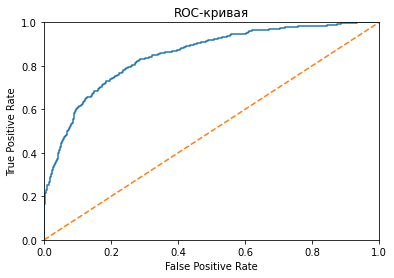

In [68]:
# Посмотрим на ROC кривую

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [9]:
feature_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

# Общий вывод

1. Поставленная цели по достижению на тестовой выборке F1 меры в 0.59 была достигнута. Итоговое значение получилось равным 0.596
2. В ходе работы мы провели первичный анализ данных, избавились от пропусков, удалили столбцы с данными ненужными для работы моделей машинного обучения.
3. Были обработаны категориальные признаки и стандартизированы числовые.
4. Была проделена комплексная работа по оценке трех моделей машинного обучения с приминением различных методик избавления от дисбаланса целевого признака, таких как:
    - Выравнивание веса классов
    - Уменьшение доли отрицательного класса
    - Уменьшение доли положительного класса
    - Комбинированные метод выравнивания
5. Итогом четвертого пункта стало выявление лидера среди обученных моделей. Ей стала модель случайного леса с количеством деревьем 20 и глубиной дерева в 5 при даунсемплинге классов целевого признака.
6. Увеличив порог классификации мы улучшили и без того выдающиеся результаты предсказаций нашей модели, доведя точность предсказания до 0.84.

Таким образом мы выполнили все поставленные перед нами цели и гордо можем предлагать банку нашу модель машинного обучения для предсказания поведения его клиентов.
